In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, RepeatVector
import pandas as pd
import csv
from datetime import datetime

2023-04-19 08:50:50.578773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 08:50:53.544491: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 08:50:53.547895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:51:03.054498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

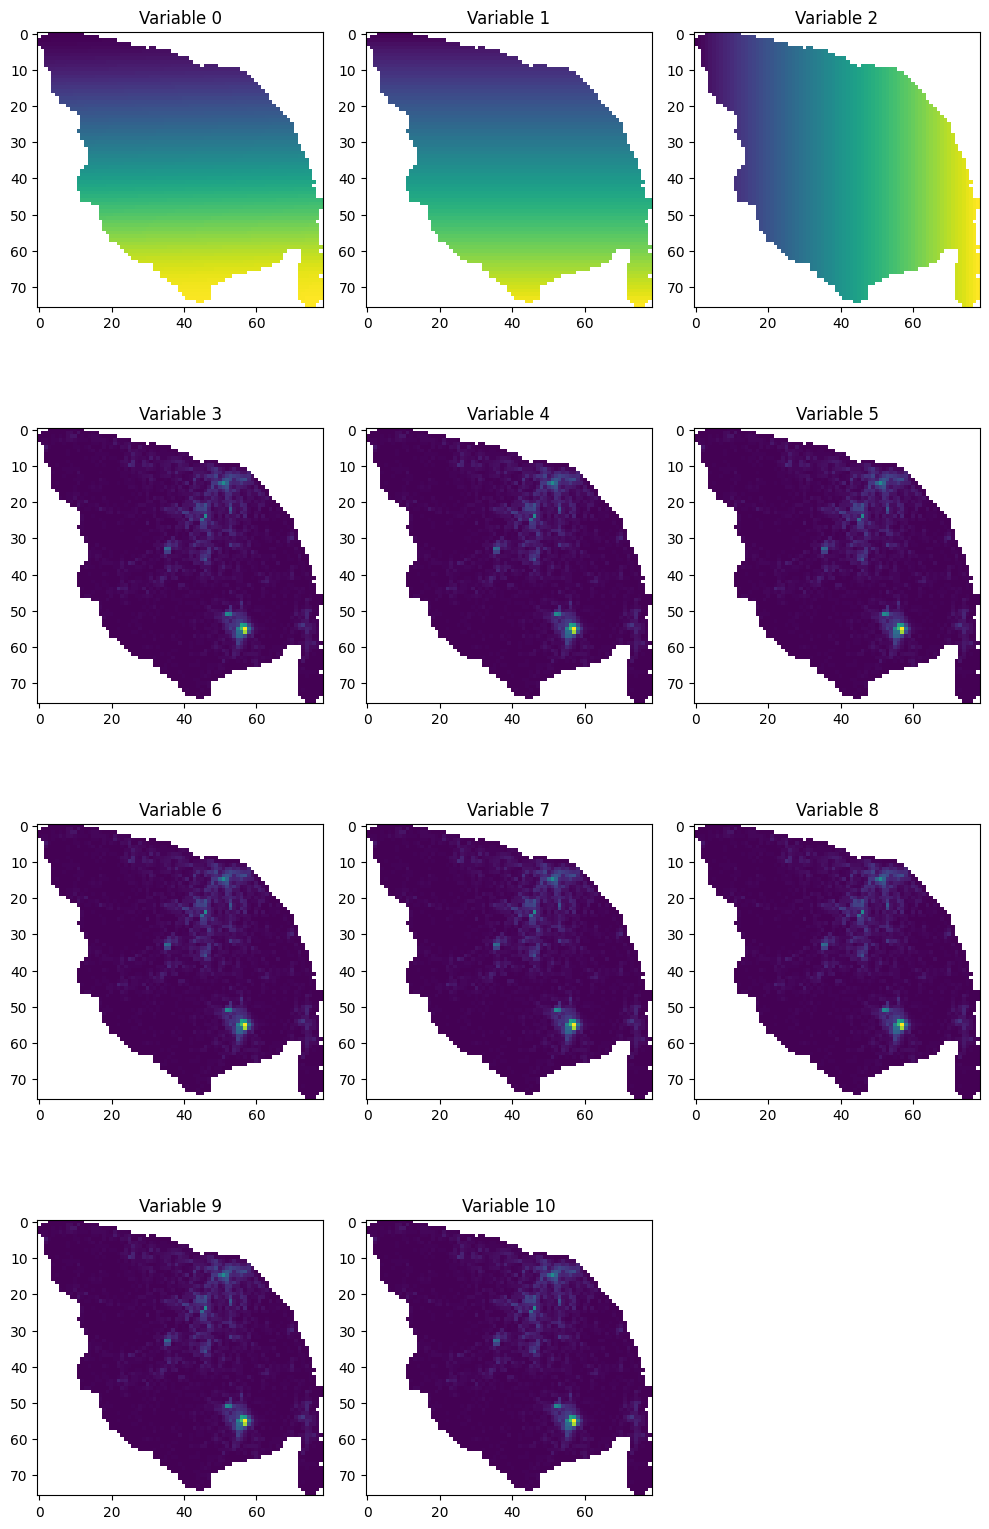

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [4]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape, forecast_range):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100))
    model.add(RepeatVector(forecast_range))
    model.add(LSTM(units=100, return_sequences= True))
    model.add(TimeDistributed(Dense(output_shape)))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [5]:
N_IN_24_H = 24*4
FORECAST_RANGE = 4 # 1 hour

In [6]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift, forecast_range):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-forecast_range], tf.stack([window[-i,:,:,0][relevant_cells_mask] for i in range(forecast_range)])))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [7]:
def ingestion(data, window_size, shift, batch_size, forecast_range):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    test_dataset = windowed_dataset(x_data_test, relevant_cells_mask, window_size, batch_size, shift, forecast_range)

    return train_dataset, validation_dataset, test_dataset, output_shape

In [8]:
def train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis):
    model = CNN_LSTM(input_shape, output_shape, forecast_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    # the patience parameter is the number of epochs with no improvement after which training will be stopped.
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[callback])

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

# Run experiment

In [9]:
def experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5', forecast_range=4):
    # Ingestion
    train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift, batch_size, forecast_range)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return model, train_loss, val_loss, test_dataset

To run single experiment:
`model, train_loss, val_loss = experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=1e-2, vis=True, model_path='model.h5')`

## Iterate over multiple window_sizes

Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 08:52:47.145811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-19 08:52:47.149624: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-19 08:52:51.784519: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2237906944 exceeds 10% of free system memory.
2023-04-19 08:53:04.535349: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 559092480 exceeds 10% of free 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 96, 76, 79, 4)    132       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 96, 38, 39, 2)    34        


2023-04-19 08:53:13.561209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:53:13.563514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:53:13.564534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 96, 19, 19, 2)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 96, 19, 19, 1)    9         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 96, 9, 9, 1)      0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 96, 81)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               72800     
          

2023-04-19 08:53:13.920266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2237906944 exceeds 10% of free system memory.
2023-04-19 08:53:14.554665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:53:14.554956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:53:15.432181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate

      8/Unknown - 11s 716ms/step - loss: 601.5643

2023-04-19 08:53:28.048939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:53:28.049238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:53:28.358417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 14s 1s/step - loss: 601.5643 - val_loss: 242.4124
dict_keys(['loss', 'val_loss'])


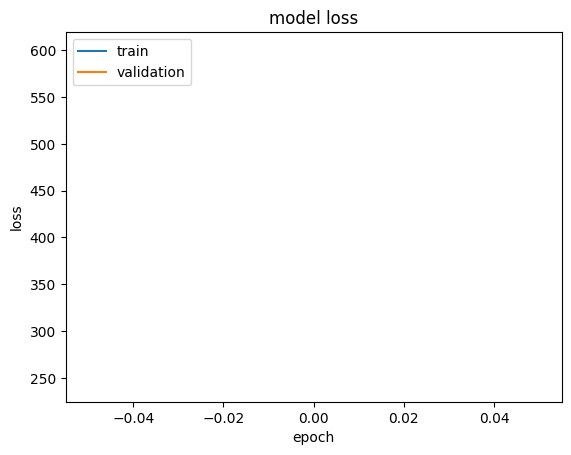

FINISH:  ['2023-04-19 08:53:30', 48, [601.5642700195312], [242.41244506835938]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 08:53:42.985656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:53:43.041600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:53:43.042850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 96, 76, 79, 4)    132       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 08:53:43.523087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:53:43.524488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:53:43.525439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 29s 2s/step - loss: 605.7638

2023-04-19 08:54:16.776393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:54:16.777563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:54:17.699370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 36s 3s/step - loss: 605.7638 - val_loss: 243.4420
dict_keys(['loss', 'val_loss'])


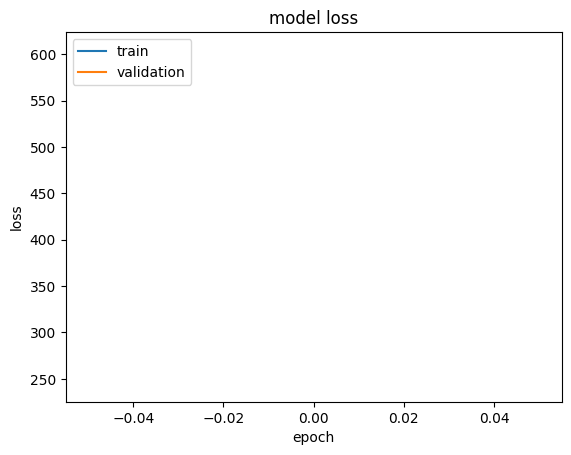

FINISH:  ['2023-04-19 08:54:22', 96, [605.7637939453125], [243.4420166015625]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 08:54:51.704403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:54:51.705915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:54:51.706787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 08:54:51.917203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:54:51.918566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:54:51.920555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 64s 4s/step - loss: 606.4460

2023-04-19 08:55:58.008483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:55:58.009824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:55:58.969233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 76s 5s/step - loss: 606.4460 - val_loss: 238.1769
dict_keys(['loss', 'val_loss'])


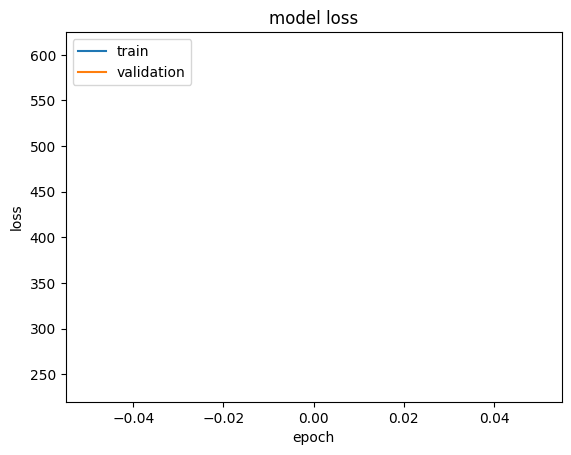

FINISH:  ['2023-04-19 08:56:10', 144, [606.4459838867188], [238.17691040039062]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 08:57:00.220610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:57:00.222023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:57:00.222948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 08:57:00.440543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:57:00.442939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:57:00.443928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     15/Unknown - 36s 2s/step - loss: 587.3845

2023-04-19 08:57:38.366788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:57:38.368990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:57:39.469294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

15/15 [==============================] - 44s 2s/step - loss: 587.3845 - val_loss: 216.6817
dict_keys(['loss', 'val_loss'])


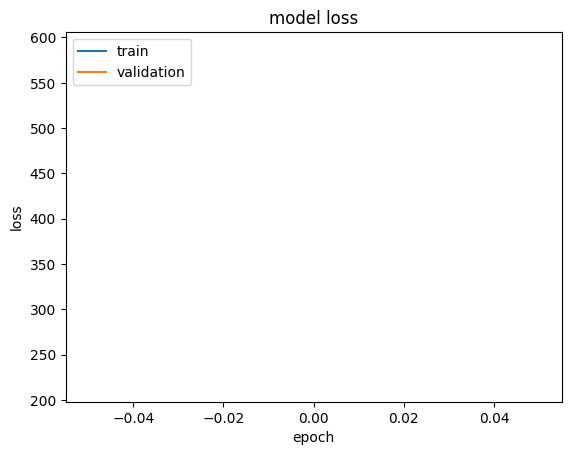

FINISH:  ['2023-04-19 08:57:45', 192, [587.384521484375], [216.68167114257812]]
Whole dataset shape: (8736, 76, 79, 11)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-04-19 08:58:47.735324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 08:58:47.737537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 08:58:47.738591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 time_distributed_32 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 96, 19, 19, 1)    9         
 stributed)                                                      
                                                                 
 time_dist

2023-04-19 08:58:48.529961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:58:48.530272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 08:58:48.873302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

     15/Unknown - 78s 4s/step - loss: 595.1254

2023-04-19 09:00:09.522440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:00:09.522901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:00:10.433097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

15/15 [==============================] - 88s 5s/step - loss: 595.1254 - val_loss: 208.9736
dict_keys(['loss', 'val_loss'])


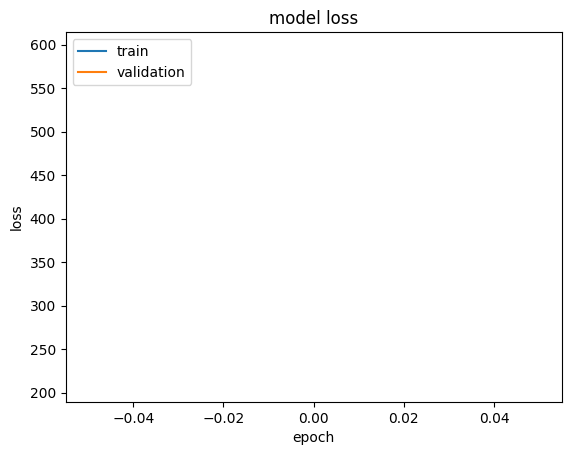

FINISH:  ['2023-04-19 09:00:17', 288, [595.1254272460938], [208.97357177734375]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 09:00:32.764408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:00:32.765849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:00:32.766775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 09:00:32.966591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2023-04-19 09:00:33.593695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:00:33.593985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder t

     15/Unknown - 95s 5s/step - loss: 602.8137

2023-04-19 09:02:09.499886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:02:09.500218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:02:10.073720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

15/15 [==============================] - 110s 6s/step - loss: 602.8137 - val_loss: 205.9684
dict_keys(['loss', 'val_loss'])


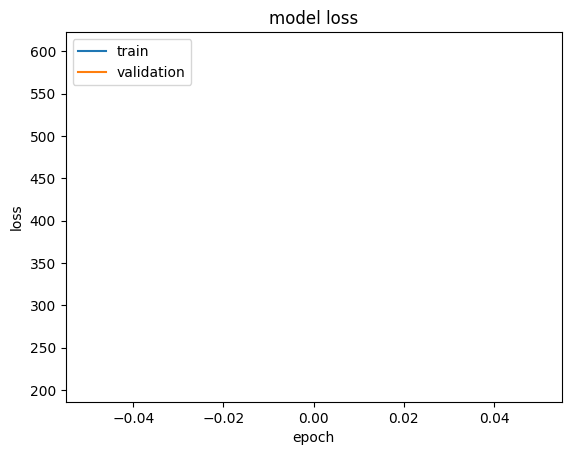

FINISH:  ['2023-04-19 09:02:24', 384, [602.813720703125], [205.96835327148438]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 09:02:49.701616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:02:49.703115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:02:49.704060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 09:02:49.933633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:02:49.935837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:02:49.936730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     28/Unknown - 101s 3s/step - loss: 560.6367

2023-04-19 09:04:32.603835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:04:32.605434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:04:33.346168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

28/28 [==============================] - 115s 3s/step - loss: 560.6367 - val_loss: 170.7440
dict_keys(['loss', 'val_loss'])


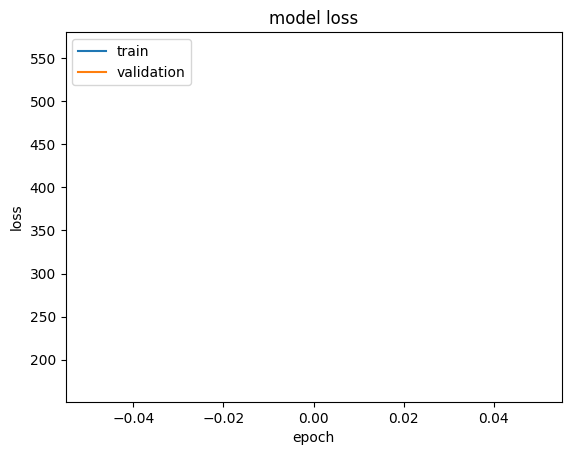

FINISH:  ['2023-04-19 09:04:46', 480, [560.63671875], [170.74404907226562]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 09:05:51.820881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:05:51.824064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:05:51.825497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 09:05:52.196049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:05:52.198917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:05:52.200224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     28/Unknown - 120s 3s/step - loss: 563.8384

2023-04-19 09:07:53.432402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:07:53.435923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:07:54.109908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

28/28 [==============================] - 130s 4s/step - loss: 563.8384 - val_loss: 170.7043
dict_keys(['loss', 'val_loss'])


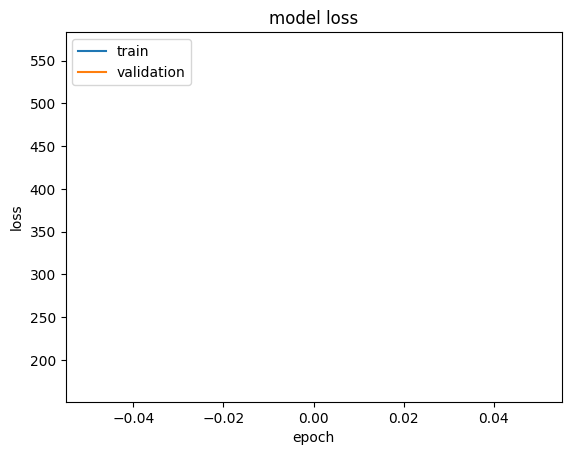

FINISH:  ['2023-04-19 09:08:04', 576, [563.83837890625], [170.704345703125]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 09:08:38.551673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:08:38.554628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:08:38.555520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 09:08:39.367398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:08:39.367695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:08:39.740500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

     27/Unknown - 119s 4s/step - loss: 575.0918

2023-04-19 09:10:40.036534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:10:40.037128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:10:41.180698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

27/27 [==============================] - 133s 4s/step - loss: 575.0918 - val_loss: 170.2606
dict_keys(['loss', 'val_loss'])


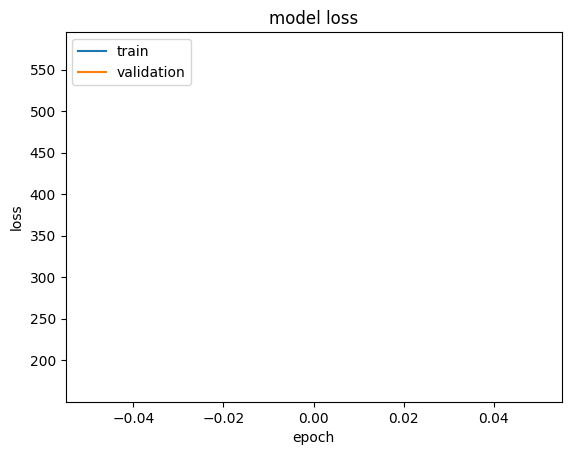

FINISH:  ['2023-04-19 09:10:53', 672, [575.091796875], [170.2606201171875]]


In [10]:
# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['12h', '24h', '36h', '48h', '72h', '96h', '5d', '6d', '7d']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 32, 16, 16, 16, 8, 8, 8]
    FORECAST_RANGE = 4 # 1 hour

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    # QUESTION: Should we also try with different forecast_ranges ??

    for i, window in enumerate([int(N_IN_24_H/2), N_IN_24_H, int(N_IN_24_H*3/2), N_IN_24_H*2, N_IN_24_H*3, N_IN_24_H*4, N_IN_24_H*5, N_IN_24_H*6, N_IN_24_H*7]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE, shift = 24, batch_size=batch_size_list[i], lr=5e-3, epochs=1, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

## Using a trained model to perform predictions

Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 09:11:45.551747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:11:45.556758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:11:45.557991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_72 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 09:11:45.849778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 09:11:45.851699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 09:11:45.852560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 34s 2s/step - loss: 592.8297

2023-04-19 09:12:21.481065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:12:21.481853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 09:12:22.243816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 38s 2s/step - loss: 592.8297 - val_loss: 247.5522
dict_keys(['loss', 'val_loss'])


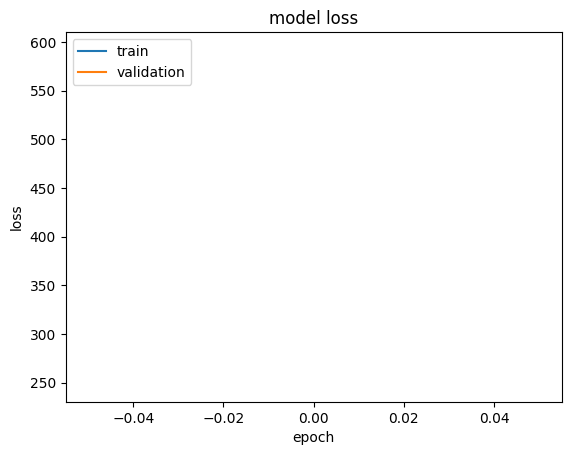

In [11]:
# Using model recursively  to predict N timesteps in the future
window_size = N_IN_24_H
model, train_loss, val_loss, test_dataset = experiment(data, window_size = window_size+1, shift = 24, batch_size=32, lr=5e-3, epochs=1, vis=True, model_path = f'models/model.h5', forecast_range= FORECAST_RANGE)

In [13]:
window_size = N_IN_24_H
train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=1, batch_size=16, forecast_range=FORECAST_RANGE)

Whole dataset shape: (8736, 76, 79, 11)


In [14]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test).numpy()
    mse = mean_squared_error(y_test, pred)
    return pred, mse

In [15]:
mse_list = []
pred_list = []

for x,y in test_dataset:
    pred, mse = predict_evaluate(model, x, y)
    mse_list.append(mse)
    pred_list.append(pred)
    

MSE = np.mean(mse_list)
print(f'MSE for test data: {MSE}')

2023-04-19 10:04:59.308997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1457,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 10:04:59.309648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1457,76,79,8]
	 [[{{node Placeholder/_0}}]]


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
# Function to convert the 1D prediction into a 2D image
def pred_into_grid(pred, ground_truth):

    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
    dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')['grelha_x', 'grelha_y', 'wkt', 'grelha_id']

    # grid indexes
    grelha_x = dfs_grid['grelha_x'].values -1
    grelha_y = dfs_grid['grelha_y'].values -1
    grelha_id =  dfs_grid['grelha_id'].values 

    grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
    grelha_id_2d[:] = np.nan
    pred_2d = grelha_id_2d.copy()
    ground_truth_2d = grelha_id_2d.copy()

    # Indices to map from
    idx_2d = np.stack([grelha_y, grelha_x])

    # Assign the elements to the regular rectangular grid
    pred_2d[tuple(idx_2d)] = pred.ravel()
    ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()

    return pred_2d, ground_truth_2d

In [ ]:
# Define some pred and ground truth here 
pred_2d, ground_truth_2d = pred_into_grid(pred, ground_truth)

fig, axs = plt.subplots(1,2)

axs[0].set_title('Predicted')
axs[0].imshow(pred_2d)

axs[1].set_title('Ground truth')
axs[1].imshow(ground_truth_2d)

# axs[2].set_title('Error (%)')
# axs[2].imshow((pred_2d-ground_truth_2d)/(ground_truth_2d))'''

In [ ]:
# TODO - convert these to function so we can view any prediction
'''grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")


# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
pred_2d = grelha_id_2d.copy()
ground_truth_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
pred_2d[tuple(idx_2d)] = pred.ravel()
ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()



In [ ]:
'''truth_stats = stats.describe(ground_truth.flatten())
pred_stats = stats.describe(pred.flatten())

print("RESULTS")
print("MSE:", mean_squared_error(ground_truth, pred))
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)'''

In [ ]:
'''fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ground_truth.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(pred.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()'''